# **CAR PRICE PREDICTION - Notebook C** 

**Tópicos neste notebook:**

5 - Data Preparation

6 - Feature Selection

7 - Machine Learning

8 - Fine Tunning

9 - Tradução e Interpretação do Erro

# Imports

In [1]:
import pandas as pd
import numpy as np
import math
import random
import re
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import xgboost as xgb

from unidecode                  import unidecode
from sklearn.preprocessing      import RobustScaler, MinMaxScaler, OrdinalEncoder, PolynomialFeatures, OneHotEncoder
from category_encoders          import TargetEncoder
from sklearn.ensemble           import RandomForestRegressor, RandomForestClassifier
from boruta                     import BorutaPy
from sklearn.feature_selection  import SelectFromModel
from sklearn.metrics            import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, make_scorer
from sklearn.linear_model       import LinearRegression, Lasso
from sklearn.tree               import DecisionTreeRegressor
from sklearn.model_selection    import KFold
from matplotlib                 import gridspec

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore')

# Configurações Gerais
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

# Helper Functions

In [2]:
# Funções para Avaliação dos Modelos
def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))

    return pd.DataFrame({'Model Name': model_name, 'MAE': mae, 'MAPE': mape, 'RMSE': rmse}, index=[0])

def cross_validation(model_name, model_ml, X, y, kfolds, n_poly_degree=3):

    kf = KFold(n_splits=kfolds)

    mae_list = []
    mape_list = []
    rmse_list = []

    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        if model_name == 'Polynomial Regression':
            
            poly = PolynomialFeatures(degree=n_poly_degree, include_bias=False)
            X_poly_train = poly.fit_transform(X_train)
            X_poly_test = poly.transform(X_test)

            model = model_ml
            model.fit(X_poly_train, y_train)
            yhat = model.predict(X_poly_test)

        else:
            model_ml.fit(X_train, y_train)
            yhat = model_ml.predict(X_test)
            
        mae = mean_absolute_error(np.expm1(y_test), np.expm1(yhat))
        mape = mean_absolute_percentage_error(np.expm1(y_test), np.expm1(yhat))
        rmse = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(yhat)))

        mae_list.append(mae)
        mape_list.append(mape)
        rmse_list.append(rmse)

    return pd.DataFrame( {'Model Name': model_name, 
                            'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 6).astype(str),
                            'MAPE CV': np.round(np.mean(mape_list), 3).astype(str) + ' +/- ' + np.round(np.std(mape_list), 6).astype(str),
                            'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 6).astype(str)}, index=[0])

# **5.0 Data Preparation**

In [3]:
df5 = pd.read_csv('../datasets/cooked_datasets/df3_processed.csv', low_memory = False)

In [4]:
# Separando colunas por numéricas e categóricas
num_attr = df5.select_dtypes(include=['int64', 'float64'])
cat_attr = df5.select_dtypes(exclude=['int64', 'float64'])

## 5.1 Normalização

In [5]:
# Normalizando a var resposta 'preco', atendendo a premissa ml.
df5['preco'] = np.log(df5['preco'])

## 5.2 Rescaling

Verifiquei as colunas utilizando o boxplot, assim decidi qual rescaling eu utilizaria em cada coluna.

In [6]:
# RobustScaler
rs_anof = RobustScaler()
rs_anom = RobustScaler()
rs_hodo = RobustScaler()
rs_cilin = RobustScaler()
rs_portas = RobustScaler()

df5['ano_de_fabricacao'] = rs_anof.fit_transform(df5[['ano_de_fabricacao']].values)
pickle.dump(rs_anof, open('../parameter/ano_de_fabricacao.pkl', 'wb'))

df5['ano_modelo'] = rs_anom.fit_transform(df5[['ano_modelo']].values)
pickle.dump(rs_anom, open('../parameter/ano_modelo.pkl', 'wb'))

df5['hodometro'] = rs_hodo.fit_transform(df5[['hodometro']].values)
pickle.dump(rs_hodo, open('../parameter/hodometro.pkl', 'wb'))

df5['cilindradas'] = rs_cilin.fit_transform(df5[['cilindradas']].values)
pickle.dump(rs_cilin, open('../parameter/cilindradas.pkl', 'wb'))

df5['num_portas'] = rs_portas.fit_transform(df5[['num_portas']].values)


# MinMaxScaler
mms_fotos = MinMaxScaler()

df5['num_fotos'] = mms_fotos.fit_transform(df5[['num_fotos']].values)


# Verificando alterações
df5.select_dtypes(include=['int64', 'float64']).head()

,num_fotos,ano_de_fabricacao,ano_modelo,hodometro,num_portas,entrega_delivery,troca,preco,cilindradas
0,0.380952,-0.2,0.00,-0.128197,0.0,0,0,11.916345,2.4
1,0.380952,-0.2,0.00,0.413261,0.0,0,0,12.309365,1.6
2,0.380952,-0.6,-0.25,0.518227,0.0,0,0,11.780746,0.0
3,0.380952,-1.0,-1.25,0.664118,0.0,0,0,11.061921,1.0
4,0.380952,0.0,0.00,-0.276512,0.0,0,0,12.493123,0.0


## 5.3 Encoding 

In [7]:
unique_counts = cat_attr.nunique()
filtered_counts = unique_counts[unique_counts > 2]
sorted_counts = filtered_counts.sort_values(ascending=False)
print(sorted_counts)

id                 23667
cidade_vendedor      523
modelo               440
marca                 39
estado_vendedor       25
cambio                 7
tipo                   7
cor                    7
ano_de_fab_bin         6
combustivel            6
categoria_marca        5
regiao                 5
anunciante             3
dtype: int64


### 5.3.1 Target Encoding

In [8]:
cols_to_encode = ['cidade_vendedor', 'modelo', 'marca', 'estado_vendedor', 'cambio', 'tipo', 'cor', 'combustivel', 'categoria_marca']

tgt_encoders_dict = {}

# Criar e treinar codificador para cada coluna
for col in cols_to_encode:
    tgt_encoder = TargetEncoder(cols=[col])
    dftx = df5[[col]]
    dfty = df5['preco']
    df5[[col]] = tgt_encoder.fit_transform(dftx, dfty)
    
    tgt_encoders_dict[f'tgt_{col}_encoder'] = tgt_encoder

    # Salvar pickle após ter selecionado as fetures
    # features_selecionadas = ['marca', 'cor', 'combustivel', 'tipo', 'cilindradas', 'cidade_vendedor','ano_de_fabricacao', 'ano_modelo', 'hodometro', 'modelo', 'cambio', 'blindado']
    # if col in features_selecionadas:
    #     with open(f'../parameter/{col}_tgt_encoder.pkl', 'wb') as file:
    #         pickle.dump(tgt_encoder, file)

### 5.3.2 Ordinal Encoder

In [9]:
# Ordenando
df5['ano_de_fab_bin'] = df5['ano_de_fab_bin'].apply(lambda x:   0 if x == '<=2000' else
                                                                1 if x == '<=2005' else
                                                                2 if x == '<=2010' else
                                                                3 if x == '<=2015' else
                                                                4 if x == '<=2020' else
                                                                5)

# Verificando
df5['ano_de_fab_bin'].sample(5)

8784     2
20956    4
6459     3
13449    4
8095     4
Name: ano_de_fab_bin, dtype: int64

### 5.3.3 One Hot Encoding

In [10]:
one_hot_encoder = OneHotEncoder(sparse=False)

# fit_transform
encoded = one_hot_encoder.fit_transform(df5[['regiao']])

# Cria um DataFrame com as colunas codificadas
encoded_df = pd.DataFrame(encoded, columns=one_hot_encoder.get_feature_names_out(['regiao']))
df5.drop('regiao', axis=1, inplace=True)
# Unindo
df5 = pd.concat([df5, encoded_df], axis=1)
df5.head()

,id,num_fotos,marca,modelo,ano_de_fabricacao,ano_modelo,hodometro,cambio,num_portas,tipo,blindado,cor,tipo_vendedor,cidade_vendedor,estado_vendedor,anunciante,entrega_delivery,troca,dono_aceita_troca,veiculo_unico_dono,revisoes_concessionaria,ipva_pago,veiculo_licenciado,garantia_de_fabrica,revisoes_dentro_agenda,preco,ano_de_fab_bin,categoria_marca,combustivel,cilindradas,turbo,offroad,regiao_Centro-Oeste,regiao_Nordeste,regiao_Norte,regiao_Sudeste,regiao_Sul
0,323085247763663990872741764627861904536,0.380952,11.554398,12.084723,-0.2,0.00,-0.128197,11.749714,0.0,11.780931,Nao,11.635202,PF,11.714482,11.641323,PF,0,0,Sim,Nao,Sim,Nao,Nao,Nao,Sim,11.916345,4,11.592748,12.087523,2.4,ASPIRADO,4X4,0.0,0.0,0.0,0.0,1.0
1,264863131275421686475285072728972496474,0.380952,11.322830,12.047237,-0.2,0.00,0.413261,11.749714,0.0,12.243005,Nao,11.635202,PF,11.632837,11.628935,PF,0,0,Sim,Nao,Nao,Nao,Nao,Nao,Nao,12.309365,4,11.315781,12.087523,1.6,TURBO,4X4,0.0,1.0,0.0,0.0,0.0
2,66199843711403276216246528249703244041,0.380952,11.540941,11.725946,-0.6,-0.25,0.518227,11.749714,0.0,11.304746,Nao,11.635202,PF,11.700363,11.607841,PF,0,0,Sim,Nao,Sim,Sim,Sim,Nao,Sim,11.780746,3,11.592748,11.818409,0.0,TURBO,4x2,0.0,0.0,0.0,1.0,0.0
3,259723171432277452721984925054195978311,0.380952,11.886961,11.605334,-1.0,-1.25,0.664118,11.749714,0.0,11.304746,Nao,11.635202,PF,11.632837,11.607841,PF,0,0,Sim,Nao,Nao,Sim,Sim,Nao,Nao,11.061921,3,11.869400,11.818409,1.0,ASPIRADO,4x2,0.0,0.0,0.0,1.0,0.0
4,198107458861275119163762018773532253229,0.380952,11.775585,11.866404,0.0,0.00,-0.276512,11.749714,0.0,12.243005,Sim,11.594116,PF,11.586247,11.607841,PF,0,0,Nao,Sim,Nao,Sim,Sim,Nao,Nao,12.493123,4,11.592748,11.428677,0.0,ASPIRADO,4x2,0.0,0.0,0.0,1.0,0.0


### 5.3.4 Convertendo para 0 ou 1

In [11]:
# Converter para 0 ou 1

# Colunas com Sim Nao
colunas_a_processar = ['blindado', 'dono_aceita_troca', 'veiculo_unico_dono', 'revisoes_concessionaria',
                       'ipva_pago', 'veiculo_licenciado', 'garantia_de_fabrica', 'revisoes_dentro_agenda']
for coluna in colunas_a_processar:
    df5[coluna] = df5[coluna].apply(lambda x: 1 if x == 'Sim' else 0)

# Colunas com nomes distintos
df5['turbo'] = df5['turbo'].apply(lambda x: 1 if x == 'Turbo' else 0)
df5['offroad'] = df5['offroad'].apply(lambda x: 1 if x == '4X4' else 0)
df5['tipo_vendedor'] = df5['tipo_vendedor'].apply(lambda x: 1 if x == 'PF' else 0)
df5['anunciante'] = df5['anunciante'].apply(lambda x: 1 if x == 'PF' else 0)

# Verificando
cols_result = ['blindado', 'dono_aceita_troca', 'veiculo_unico_dono', 'revisoes_concessionaria', 'ipva_pago', 'veiculo_licenciado', 'garantia_de_fabrica', 'revisoes_dentro_agenda', 'turbo', 'offroad', 'tipo_vendedor']
df5[cols_result].sample(3)

,blindado,dono_aceita_troca,veiculo_unico_dono,revisoes_concessionaria,ipva_pago,veiculo_licenciado,garantia_de_fabrica,revisoes_dentro_agenda,turbo,offroad,tipo_vendedor
4422,0,1,1,1,1,1,1,0,0,0,0
10204,0,1,0,0,0,0,0,0,0,0,1
20515,0,1,0,0,1,0,0,0,0,0,1


# **6.0 Feature Selection**

In [12]:
df6 = df5.copy()

## 6.1 Boruta Selection

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	35
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	35
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	35
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	35
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	35
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	35
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	35
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	7
Tentative: 	0
Rejected: 	28


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	7
Tentative: 	0
Rejected: 	28


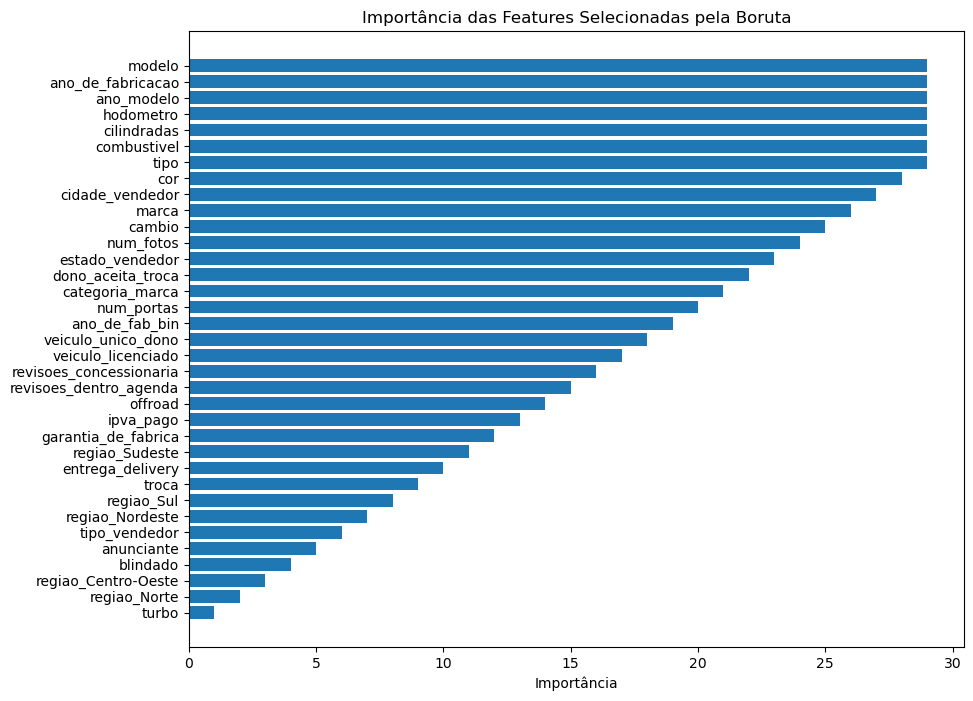



Features selecionados pelo algoritmo:
Index(['modelo', 'ano_de_fabricacao', 'ano_modelo', 'hodometro', 'tipo',
       'combustivel', 'cilindradas'],
      dtype='object')




In [13]:
def boruta_selecting(X_train, y_train, algorithm_type):
    # Mascarando dtypes para rodar o boruta
    np.float = float   
    np.int = int
    np.object = object
    np.bool = bool


    # RODANDO BORUTA
    # Treino e teste dataset Boruta
    X_train_b = X_train.values
    y_train_b = y_train.values.ravel()

    if algorithm_type == 'regressor':
        algorithm = RandomForestRegressor(n_jobs=-1)
    if algorithm_type == 'classifier':
        algorithm = RandomForestClassifier(n_jobs=-1)

    # define Boruta
    boruta = BorutaPy(algorithm, n_estimators='auto', verbose=2, random_state=7)
    boruta.fit(X_train_b, y_train_b)


    # PLOT IMPORTANCIA DAS FEATURES
    # Obtendo as posições das features em ordem decrescente com base no ranking
    boruta.ranking_ = np.max(boruta.ranking_) - boruta.ranking_ + 1
    feature_indices = np.argsort(boruta.ranking_)[::-1]
    # Nomes das features
    feature_names = X_train.columns.tolist()
    # Obtendo as importâncias das features com base nos rankings
    feature_importances = np.sort(boruta.ranking_)[::-1]
    
    # # Criando o gráfico de barras horizontais
    # plt.figure(figsize=(10, 8))
    # plt.barh(range(len(feature_indices)), feature_importances)
    # plt.yticks(range(len(feature_indices)), feature_names[feature_indices])
    # plt.xlabel('Importância')
    # plt.title('Importância das Features Selecionadas pela Boruta')
    # plt.gca().invert_yaxis()  # Inverte a ordem para a mais selecionada ficar no topo
    # plt.show()

    # Ordenando os nomes das features de acordo com os índices de importância
    feature_names_sorted = [feature_names[i] for i in feature_indices]

    # Criando o gráfico de barras horizontais com os nomes ordenados
    plt.figure(figsize=(10, 8))
    plt.barh(range(len(feature_indices)), feature_importances)
    plt.yticks(range(len(feature_indices)), feature_names_sorted)
    plt.xlabel('Importância')
    plt.title('Importância das Features Selecionadas pela Boruta')
    plt.gca().invert_yaxis()
    plt.show()

    # SELECIONANDO FEATURES
    # Best features
    cols_selected_boruta = X_train.columns[boruta.support_]
    # Not selected boruta
    cols_not_selected_boruta = np.setdiff1d(X_train.columns, cols_selected_boruta)

    print(f'\n\nFeatures selecionados pelo algoritmo:\n{cols_selected_boruta}\n\n')

    return cols_selected_boruta, cols_not_selected_boruta

# Dataset de treino e teste para a function boruta_selecting
X_train_b = df6.drop(['id', 'preco'], axis=1)
y_train_b = df6['preco']

cols_selected_boruta, cols_not_selected_boruta = boruta_selecting(X_train_b, y_train_b, 'regressor')

# OBS.: Após usar o np.int = int... e usar o boruta para descobrir as features, reinicie o kernel para o np.int voltar ao normal.

## 6.2 SelectFromModel Selection

In [14]:
# Separando features e target
X_train_fs = df6.drop(['id', 'preco'], axis=1).values
y_train_fs = df6['preco'].values

X_train_to_see_columns_selected = df6.drop(['id', 'preco'], axis=1)

# Feature Selection Model
selection_model = SelectFromModel(RandomForestRegressor(n_estimators = 100))
selection_model.fit(X_train_fs, y_train_fs)

# Features selecionadas pelo modelo
selected_feat = X_train_to_see_columns_selected.columns[(selection_model.get_support())]
print(f'As {selection_model.get_support().sum()} features mais importantes de acordo com o modelo são: {selected_feat.tolist()}')

As 6 features mais importantes de acordo com o modelo são: ['modelo', 'ano_de_fabricacao', 'ano_modelo', 'hodometro', 'cidade_vendedor', 'cilindradas']


As 10 primeiras colunas mais importantes:
['marca', 'cor', 'combustivel', 'tipo', 'cidade_vendedor', 'cilindradas', 'ano_de_fabricacao', 'ano_modelo', 'hodometro', 'modelo']


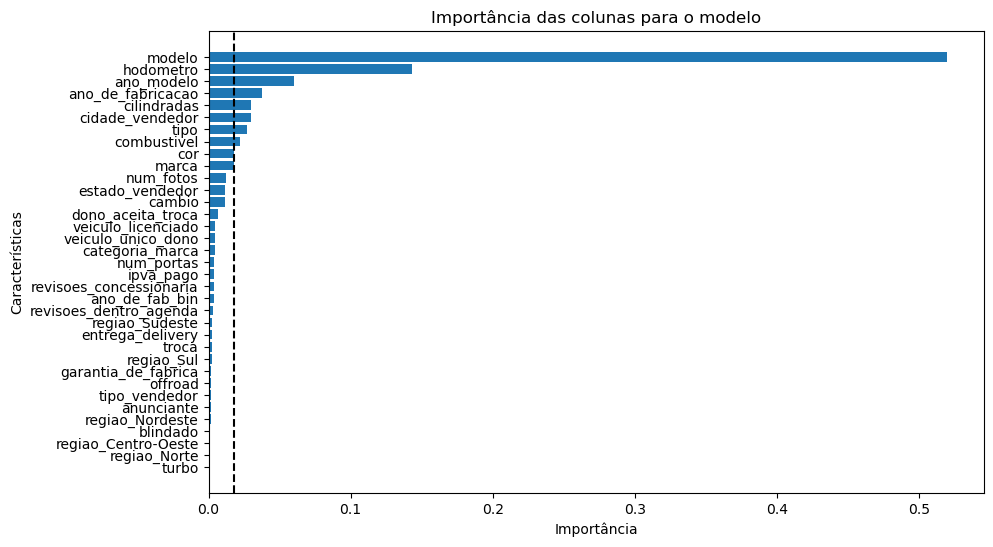

In [15]:
# Plot das % das importancias de cada coluna
importances = selection_model.estimator_.feature_importances_
feature_names = X_train_to_see_columns_selected.columns

sorted_indices = importances.argsort()
sorted_importances = importances[sorted_indices]
sorted_feature_names = [feature_names[i] for i in sorted_indices]
features_selecionadas = sorted_feature_names[-10:]
print(f'As 10 primeiras colunas mais importantes:\n{features_selecionadas}')

plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, sorted_importances)
plt.xlabel('Importância')
plt.ylabel('Características')
plt.title('Importância das colunas para o modelo')
plt.axvline(x=0.018, linestyle='--', color='black')
plt.show()

## 6.3 Filtrando datasets com as Features Selecionadas

In [16]:
features_selecionadas = ['marca', 'cor', 'combustivel', 'tipo', 'cilindradas', 'cidade_vendedor','ano_de_fabricacao', 'ano_modelo', 'hodometro', 'modelo', 'cambio', 'blindado']

### 6.3.1 Treino

In [17]:
# TREINO
x_train = df6[features_selecionadas]
y_train = df6['preco']

### 6.3.2 Teste

In [18]:
# Funções de tratamento do dataset de teste raw
def cleaning_dataset(df):
    # Removendo caracteres especiais
    df.columns = [unidecode(coluna) for coluna in df.columns]
    df.columns

    # Filling NAN
    df['num_fotos'] = df['num_fotos'].fillna(0)
    df['dono_aceita_troca'] = df['dono_aceita_troca'].fillna('False')
    df['veiculo_unico_dono'] = df['veiculo_unico_dono'].fillna('False')
    df['revisoes_concessionaria'] = df['revisoes_concessionaria'].fillna('False')
    df['ipva_pago'] = df['ipva_pago'].fillna('False')
    df['veiculo_licenciado'] = df['veiculo_licenciado'].fillna('False')
    df['garantia_de_fabrica'] = df['garantia_de_fabrica'].fillna('False')
    df['revisoes_dentro_agenda'] = df['revisoes_dentro_agenda'].fillna('False')
    df['veiculo_alienado'] = df['veiculo_alienado'].fillna(0)

    print(f'Valores NANs: {df.isna().sum().sum()} (cleaning_dataset function)')
    return df
def minority_changes(df):
    # Atribuindo Sim, Não.
    df['revisoes_dentro_agenda'] = df['revisoes_dentro_agenda'].map( {'Todas as revisões feitas pela agenda do carro': 'Sim', 'False':'Nao'} )
    df['garantia_de_fabrica'] = df['garantia_de_fabrica'].map( {'Garantia de fábrica': 'Sim', 'False':'Nao'} )
    df['veiculo_licenciado'] = df['veiculo_licenciado'].map( {'Licenciado': 'Sim', 'False':'Nao'} )
    df['ipva_pago'] = df['ipva_pago'].map( {'IPVA pago': 'Sim', 'False':'Nao'} )
    df['revisoes_concessionaria'] = df['revisoes_concessionaria'].map( {'Todas as revisões feitas pela concessionária': 'Sim', 'False':'Nao'} )
    df['blindado'] = df['blindado'].map( {'S': 'Sim', 'N': 'Nao'} )
    df['dono_aceita_troca'] = df['dono_aceita_troca'].map( {'Aceita troca': 'Sim', 'False':'Nao'} )
    df['veiculo_unico_dono'] = df['veiculo_unico_dono'].map( {'Único dono': 'Sim', 'False':'Nao'} )

    # Resumindo anunciante
    anunciante = {'Pessoa Física':'PF', 'Loja':'PJ', 'Concessionária':'RV', 'Acessórios e serviços para autos':'PJ'}
    df['anunciante'] = df['anunciante'].map(anunciante)

    # Atribuindo siglas ao estado_vendedor - note que Amapá e Distrito federal não estão presentes neste dataset
    sigla_estado = { 'São Paulo (SP)':'SP', 'Rio Grande do Sul (RS)':'RS', 'Minas Gerais (MG)':'MG', 'Paraná (PR)':'PR', 
        'Rio de Janeiro (RJ)':'RJ', 'Maranhão (MA)':'MA', 'Santa Catarina (SC)':'SC', 'Alagoas (AL)':'AL', 
        'Bahia (BA)':'BA', 'Goiás (GO)':'GO', 'Rio Grande do Norte (RN)':'RN', 'Pernambuco (PE)':'PE', 
        'Mato Grosso (MT)':'MT', 'Pará (PA)':'PA', 'Ceará (CE)':'CE', 'Amazonas (AM)':'AM', 'Espírito Santo (ES)':'ES',
        'Rondônia (RO)':'RO', 'Paraíba (PB)':'PB', 'Tocantins (TO)':'TO', 'Acre (AC)':'AC', 'Sergipe (SE)':'SE', 
        'Mato Grosso do Sul (MS)':'MS', 'Roraima (RR)':'RR', 'Piauí (PI)':'PI' }
    df['estado_vendedor'] = df['estado_vendedor'].map(sigla_estado)

    # Tipo do veículo
    tipo = {'Sedã':'Sedan', 'Picape':'Picape', 'Utilitário esportivo':'Util_Esp', 'Hatchback':'Hatchback', 'Perua/SW':'Perua', 'Cupê':'Cupe', 'Minivan':'Minivan'}
    df['tipo'] = df['tipo'].map(tipo)

    # Cambio do veículo
    cambio = { 'Automática':'Automatica', 'Manual':'Manual', 'CVT':'CVT', 
                'Automatizada':'Automatizada', 'Semi-automática':'Semi-auto', 
                'Automatizada DCT':'Automatizada_DCT', 
                'Automática Sequencial':'Auto_Sequencial' }
    df['cambio'] = df['cambio'].map(cambio)

    # Removendo acento do conteudo das células
    colunas_acento = ['marca', 'modelo', 'cidade_vendedor']
    for col in colunas_acento:
        df[col] = df[col].apply(lambda x: unidecode(x))


    print(f'Valores NANs: {df.isna().sum().sum()} (minority_changes function)')
    return df
def feature_eng(df):

    # ano de fabricacao
    df['ano_de_fab_bin'] = df['ano_de_fabricacao'].apply(lambda x: '<=2000' if x<=2000 else
                                                                    '<=2005' if x<=2005 else
                                                                    '<=2010' if x<=2010 else
                                                                    '<=2015' if x<=2015 else
                                                                    '<=2020' if x<=2020 else
                                                                    '<=2025' if x<=2025 else 0)

    # categoria marca
    popular_baixo_padrao = ['FIAT','SUZUKI','CHEVROLET','SMART','HYUNDAI','LIFAN','SSANGYONG','RENAULT','DODGE','ALFA ROMEO','CITROËN','CHRYSLER','BRM','EFFA']
    popular_alto_padrao = ['JEEP','SUBARU','FORD','KIA','CHERY','PEUGEOT','VOLKSWAGEN','NISSAN','JAC','HONDA','MITSUBISHI']
    luxo = ['VOLVO','LEXUS','MERCEDES-BENZ','FERRARI','AUDI','TOYOTA','IVECO','MINI','TROLLER']
    superluxo = ['PORSCHE','RAM','LAMBORGHINI','JAGUAR','LAND ROVER','MASERATI','BMW']
    df['categoria_marca'] = df['marca'].apply(lambda x:   'popular_baixo_padrao' if x in popular_baixo_padrao else
                                                            'popular_alto_padrao' if x in popular_alto_padrao else
                                                            'luxo' if x in luxo else
                                                            'superluxo' if x in superluxo 
                                                            else 'nao_identificado')

    # combustivel
    df['combustivel'] = df['versao'].apply(lambda x: re.search("GASOLINA", str(x)).group() if re.search("GASOLINA", str(x)) is not None else 
                                                        re.search("FLEX", str(x)).group() if re.search("FLEX", str(x)) is not None else
                                                        re.search("HYBRID", str(x)).group() if re.search("HYBRID", str(x)) is not None else
                                                        re.search("DIESEL", str(x)).group() if re.search("DIESEL", str(x)) is not None else
                                                        re.search("ELECTRIC", str(x)).group() if re.search("ELECTRIC", str(x)) is not None else
                                                        re.search("ELÉTRICO", str(x)).group() if re.search("ELÉTRICO", str(x)) is not None else
                                                        re.search("HÍBRIDO", str(x)).group() if re.search("HÍBRIDO", str(x)) is not None else
                                                        re.search("GÁS", str(x)).group() if re.search("GÁS", str(x))  is not None else "DESCONHECIDO")                                                   
    df['combustivel'] = df['combustivel'].map( {'DIESEL':'DIESEL', 'FLEX':'FLEX', 'GASOLINA':'GASOLINA',
                                                'DESCONHECIDO':'NI', 'HYBRID':'HIBRIDO', 'HÍBRIDO':'HIBRIDO','ELÉTRICO':'ELÉTRICO', 'ELECTRIC': 'ELÉTRICO'})

    # Cilindradas
    cilindradas = []
    for i in range(len(df)):
        try:
            # versao = df['versao'][i]
            cilindrada = re.search(r"[0-9]{1}\.[0-9]{1}", df['versao'][i]).group()
        except:
            cilindrada = 0
        cilindradas.append(cilindrada)
    df_cilindradas = pd.DataFrame (cilindradas, columns = ['cilindradas'])
    df = pd.concat([df, df_cilindradas], axis=1)
    df['cilindradas'] = df['cilindradas'].astype(float)

    # turbo
    turbo_list = []
    for i in range(len(df)):
        try:
            turbo = re.search("TURBO", df['versao'][i]).group()
        except:
            turbo = "ASPIRADO"
        turbo_list.append(turbo)
    df_turbo = pd.DataFrame (turbo_list, columns = ['turbo'])
    df = pd.concat([df, df_turbo], axis=1)

    # 4x4
    offroad_list = []
    for i in range(len(df)):
        try:
            offroad = re.search("4X4", df['versao'][i]).group()
        except:
            offroad = "4x2"
        offroad_list.append(offroad)
    df_offroad = pd.DataFrame (offroad_list, columns = ['offroad'])
    df = pd.concat([df, df_offroad], axis=1)

    # Filtragem
    # Filtragem/remoção/drop de colunas com valores constantes ou 100% nulos.
    cols_drop = df.nunique()[df.nunique() <= 1].index.tolist() # Dropando 
    df = df.drop(cols_drop, axis=1)
    # Remoção da coluna versão, devido a feature engineering aplicada nela
    df = df.drop(['versao'], axis=1)

    print(f'Valores NANs: {df.isna().sum().sum()} (feature_eng function)')
    return df
def rescaling_encoding(df):
    # Rescaling
    # RobustScaler
    df['ano_de_fabricacao'] = rs_anof .transform(df[['ano_de_fabricacao']].values)
    df['ano_modelo'] = rs_anom.transform(df[['ano_modelo']].values)
    df['hodometro'] = rs_hodo.transform(df[['hodometro']].values)
    df['num_portas'] = rs_portas.transform(df[['num_portas']].values)
    df['cilindradas'] = rs_cilin.transform(df[['cilindradas']].values)
    # MinMaxScaler
    df['num_fotos'] = mms_fotos.transform(df[['num_fotos']].values)


    # Encoding --------------////-------------------- 
    # Target Encoding
    cols_to_encode = ['cidade_vendedor', 'modelo', 'marca', 'estado_vendedor', 'cambio', 'tipo', 'cor', 'combustivel', 'categoria_marca']
    
    for col in cols_to_encode:
        # Carregar o encoder treinado
        tgt_encoder = tgt_encoders_dict[f'tgt_{col}_encoder']
        
        # Aplicar a transformação nos dados de teste
        df[[col]] = tgt_encoder.transform(df[[col]])


    # Ordinal Encoding
    df['ano_de_fab_bin'] = df['ano_de_fab_bin'].apply(lambda x:   0 if x == '<=2000' else
                                                                    1 if x == '<=2005' else
                                                                    2 if x == '<=2010' else
                                                                    3 if x == '<=2015' else
                                                                    4 if x == '<=2020' else
                                                                    5)
    
    # Converter para 0 ou 1
    # Colunas com Sim Nao
    colunas_a_processar = ['blindado', 'dono_aceita_troca', 'veiculo_unico_dono', 'revisoes_concessionaria',
                        'ipva_pago', 'veiculo_licenciado', 'garantia_de_fabrica', 'revisoes_dentro_agenda']
    for coluna in colunas_a_processar:
        df[coluna] = df[coluna].apply(lambda x: 1 if x == 'Sim' else 0)

    # Colunas com nomes distintos
    df['turbo'] = df['turbo'].apply(lambda x: 1 if x == 'Turbo' else 0)
    df['offroad'] = df['offroad'].apply(lambda x: 1 if x == '4X4' else 0)
    df['tipo_vendedor'] = df['tipo_vendedor'].apply(lambda x: 1 if x == 'PF' else 0)
    df['anunciante'] = df['anunciante'].apply(lambda x: 1 if x == 'PF' else 0)

    return df

In [19]:
# TESTE
x_test_raw = pd.read_csv('../datasets/raw_datasets/test_raw_from_split_train.csv')

# Limpezas e Feature Engineering
df_aux_test = cleaning_dataset(x_test_raw)
df_aux_test = minority_changes(df_aux_test)
df_aux_test = feature_eng(df_aux_test)
# Rescaling e Encoding
df_aux_test = rescaling_encoding(df_aux_test)
# Filtrando - feature selection 
x_test = df_aux_test[features_selecionadas]
y_test = df_aux_test['preco'] # não precisa aplicar exp1, pois não foi normalizado.

print(f'Dataset x_test com ({len(features_selecionadas)}) colunas.')
# print(f'Dataset y_test com {y_test.shape[1]} coluna.')

Valores NANs: 0 (cleaning_dataset function)
Valores NANs: 0 (minority_changes function)
Valores NANs: 0 (feature_eng function)
Dataset x_test com (12) colunas.


In [20]:
# Verificando o dataset de teste
df_aux_test.head()

,id,num_fotos,marca,modelo,ano_de_fabricacao,ano_modelo,hodometro,cambio,num_portas,tipo,blindado,cor,tipo_vendedor,cidade_vendedor,estado_vendedor,anunciante,entrega_delivery,troca,dono_aceita_troca,veiculo_unico_dono,revisoes_concessionaria,ipva_pago,veiculo_licenciado,garantia_de_fabrica,revisoes_dentro_agenda,preco,ano_de_fab_bin,categoria_marca,combustivel,cilindradas,turbo,offroad
0,174158513088796592806405616354018132916,0.380952,11.660873,11.702554,0.6,1.0,-0.421360,11.749714,0.0,11.571572,0,11.635202,0,11.875517,11.821813,0,False,False,1,0,0,1,1,0,0,176649.291489,5,11.592748,11.428677,-0.8,0,0
1,258739094963319078702833465174152949981,0.380952,11.322830,11.333239,0.0,0.0,-0.261596,11.749714,0.0,11.571572,0,11.635202,1,11.680007,11.739647,1,False,False,0,0,0,1,1,0,0,63887.181849,4,11.315781,11.428677,-1.2,0,0
2,308044418635815622191514066805307476358,0.000000,11.660873,11.702554,0.6,1.0,-0.134365,11.749714,0.0,11.571572,0,11.360121,0,11.680007,11.739647,0,False,False,1,1,0,1,1,0,0,110585.626201,5,11.592748,11.428677,-0.8,0,0
3,274993703978196215848880951781280902334,0.380952,11.540941,12.030224,0.6,1.0,-0.883172,11.749714,-2.0,11.780931,0,11.635202,1,11.753524,11.641323,1,False,False,1,0,1,0,0,1,1,417461.596397,5,11.592748,12.087523,0.0,0,1
4,231848848645830507022484988656002410939,0.619048,11.540941,11.566137,0.2,0.5,-0.569202,11.749714,0.0,11.571572,0,11.635202,0,11.576151,11.607841,0,False,False,1,0,0,0,0,0,0,118224.015684,4,11.592748,11.428677,-2.0,0,0


# **7.0 Machine Learning**

## 7.1 Modelo de Média

In [21]:
# Média da coluna target
media_y_test = y_test.mean()
# Coluna yhat_baseline com todas as linhas com o mesmo valor da média
yhat_baseline  = pd.Series([media_y_test] * len(y_test))
baseline_result = ml_error('Average Model', y_test, yhat_baseline)
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,58974.480073,0.607798,79653.492144


## 7.2 Linear Regression Model

In [22]:
lr = LinearRegression()
lr.fit(x_train, y_train)
yhat = lr.predict(x_test)
lr_result = ml_error('Linear Regression', y_test, np.expm1(yhat))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,31064.729108,0.253662,47756.379184


### 7.2.1 Linear Regression Model - Cross Validation

In [23]:
lr_result_cv = cross_validation('Linear Regression', LinearRegression(), x_train, y_train, 5)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,31796.89 +/- 500.667377,0.253 +/- 0.001976,51222.13 +/- 2988.911712


## 7.3 Linear Regression Regularized Model - Lasso

In [24]:
lss = Lasso(alpha=0.01).fit(x_train, y_train)
yhat = lss.predict(x_test)
lss_result = ml_error( 'Linear Regression - Lasso', y_test, np.expm1(yhat))
lss_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,32381.554693,0.265508,49877.337671


### 7.3.1 Lasso - Cross Validation

In [25]:
lss_result_cv = cross_validation('Lasso', Lasso(), x_train, y_train, 5)
lss_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,57385.15 +/- 748.484266,0.505 +/- 0.005208,84444.63 +/- 3154.7482


## 7.4 Decision Tree Regressor

In [26]:
dtree = DecisionTreeRegressor()
dtree.fit(x_train, y_train)
yhat = dtree.predict(x_test)
dtree_result = ml_error('Decision Tree Regressor', y_test, np.expm1(yhat))
dtree_result.round(3)

,Model Name,MAE,MAPE,RMSE
0,Decision Tree Regressor,37186.524,0.306,58231.145


### 7.4.1 Decision Tree Regression - Cross Validation

In [27]:
dtree_result_cv = cross_validation('Decision Tree Regressor', DecisionTreeRegressor(), x_train, y_train, 5)
dtree_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Decision Tree Regressor,36891.19 +/- 1030.538673,0.305 +/- 0.00682,58846.47 +/- 4150.006351


## 7.5 Random Forest Regressor

In [28]:
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, y_train )
yhat = rf.predict(x_test)
rf_result = ml_error('Random Forest Regressor', y_test,  np.expm1(yhat))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,27234.595321,0.221531,41625.304916


### 7.5.1 Random Forest Regressor - Cross Validation

In [29]:
rf_result_cv = cross_validation('Random Forest Regressor', rf, x_train, y_train, 5)
rf_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,26944.15 +/- 449.169727,0.217 +/- 0.001813,43657.44 +/- 3416.05988


## 7.6 XGBoost Regressor

In [30]:
model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators=100,
                             eta = 0.3,
                             max_depth=6,
                             subsample=1,
                             colsample_bytree=1).fit(x_train, y_train)
yhat = model_xgb.predict(x_test)
xgb_result = ml_error('XGBoost Regressor', y_test, np.expm1(yhat))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,26897.101209,0.218279,41685.27409


### 7.6.1 XGBoost Regressor - Cross Validation

In [31]:
xgb_result_cv = cross_validation('XGBoost', model_xgb, x_train, y_train, 5)
xgb_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost,26765.37 +/- 511.927875,0.215 +/- 0.001956,43048.82 +/- 3084.745074


## 7.7 Comparing Model's Performance

### 7.7.1 Single Performance

In [32]:
single_model_result = pd.concat([baseline_result, lr_result, lss_result, dtree_result, rf_result, xgb_result])
round(single_model_result.sort_values('RMSE'), 3)

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,27234.595,0.222,41625.305
0,XGBoost Regressor,26897.101,0.218,41685.274
0,Linear Regression,31064.729,0.254,47756.379
0,Linear Regression - Lasso,32381.555,0.266,49877.338
0,Decision Tree Regressor,37186.524,0.306,58231.145
0,Average Model,58974.480,0.608,79653.492


### 7.7.2 Real Performance - CV

In [33]:
cv_model_result = pd.concat([lr_result_cv, lss_result_cv, dtree_result_cv,rf_result_cv, xgb_result_cv])
cv_model_result.sort_values('RMSE CV')

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost,26765.37 +/- 511.927875,0.215 +/- 0.001956,43048.82 +/- 3084.745074
0,Random Forest Regressor,26944.15 +/- 449.169727,0.217 +/- 0.001813,43657.44 +/- 3416.05988
0,Linear Regression,31796.89 +/- 500.667377,0.253 +/- 0.001976,51222.13 +/- 2988.911712
0,Decision Tree Regressor,36891.19 +/- 1030.538673,0.305 +/- 0.00682,58846.47 +/- 4150.006351
0,Lasso,57385.15 +/- 748.484266,0.505 +/- 0.005208,84444.63 +/- 3154.7482


# **8.0 Hyperparameter Fine Tunning**

## 8.1 Random Search

In [34]:
param = {
        'n_estimators': [1500, 1700, 2500, 3000, 3500],
        'eta': [0.01, 0.03],
        'max_depth': [3, 5, 9],
        'subsample': [0.1, 0.5, 0.7],
        'colsample_bytree': [0.3, 0.7, 0.9],
        'min_child_weight': [3, 8, 15]
        }
max_eval = 10
final_result = pd.DataFrame()

for i in range(max_eval):
    hp = {k: random.sample(v, 1)[0] for k, v in param.items()} 
    print(hp)

    # model
    model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror',
                                n_estimators = hp['n_estimators'],
                                eta = hp['eta'],
                                max_depth = hp['max_depth'],
                                subsample = hp['subsample'],
                                colsample_bytree = hp['colsample_bytree'],
                                min_child_weight = hp['min_child_weight'])

    result = cross_validation('XGBoost Regressor', model_xgb, x_train, y_train, 5)
    final_result = pd.concat([final_result, result])

final_result

## 8.2 Final Model

In [35]:
param_tuned = {
        'n_estimators': 3000,
        'eta': 0.03,
        'max_depth': 5,
        'subsample': 0.7,
        'colsample_bytree': 0.7,
        'min_child_weight': 3}

# # Melhor encontrada 
param_tuned = {'n_estimators': 1700, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.5, 'colsample_bytree': 0.3, 'min_child_weight': 15}

In [36]:
model_xgb_tuned = xgb.XGBRegressor(objective = 'reg:squarederror',
                                    n_estimators = param_tuned['n_estimators'],
                                    eta = param_tuned['eta'],
                                    max_depth = param_tuned['max_depth'],
                                    subsample = param_tuned['subsample'],
                                    colsample_bytree = param_tuned['colsample_bytree'],
                                    min_child_weight = param_tuned['min_child_weight']).fit(x_train, y_train)
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

xgb_result_tuned = ml_error('XGBoost Regressor', y_test, np.expm1(yhat_xgb_tuned)) 
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,26050.356514,0.211646,40354.746176


In [37]:
# Saving xgb model
pickle.dump(model_xgb_tuned, open('/Users/andre/repos/cursos_ds/9_car_price_prediction/model/model_car_price_pred.pkl', 'wb'))

# 9.0 Tradução e Interpretação do Erro

In [119]:
df9 = df_aux_test.copy()

In [120]:
# Retornando preço predito para valores originais. Obs.: df9['preco'] já no valor original
df9['preco_prediction'] = np.expm1(yhat_xgb_tuned)

# Erro Predito vs Real
df9['preco_medio'] = df9['preco'].mean()
df9['baseline_error'] = df9['preco_medio'] - df9['preco']
df9['error'] = df9['preco_prediction'] - df9['preco']

# Error Rate
df9['error_rate'] = df9['preco_prediction'] / df9['preco']
df9['error_rate_baseline'] = df9['preco_medio'] / df9['preco']

# APE
df9['APE'] = (df9['error'] / df9['preco'])*100
df9['APE'] = df9['APE'].abs().round(2)

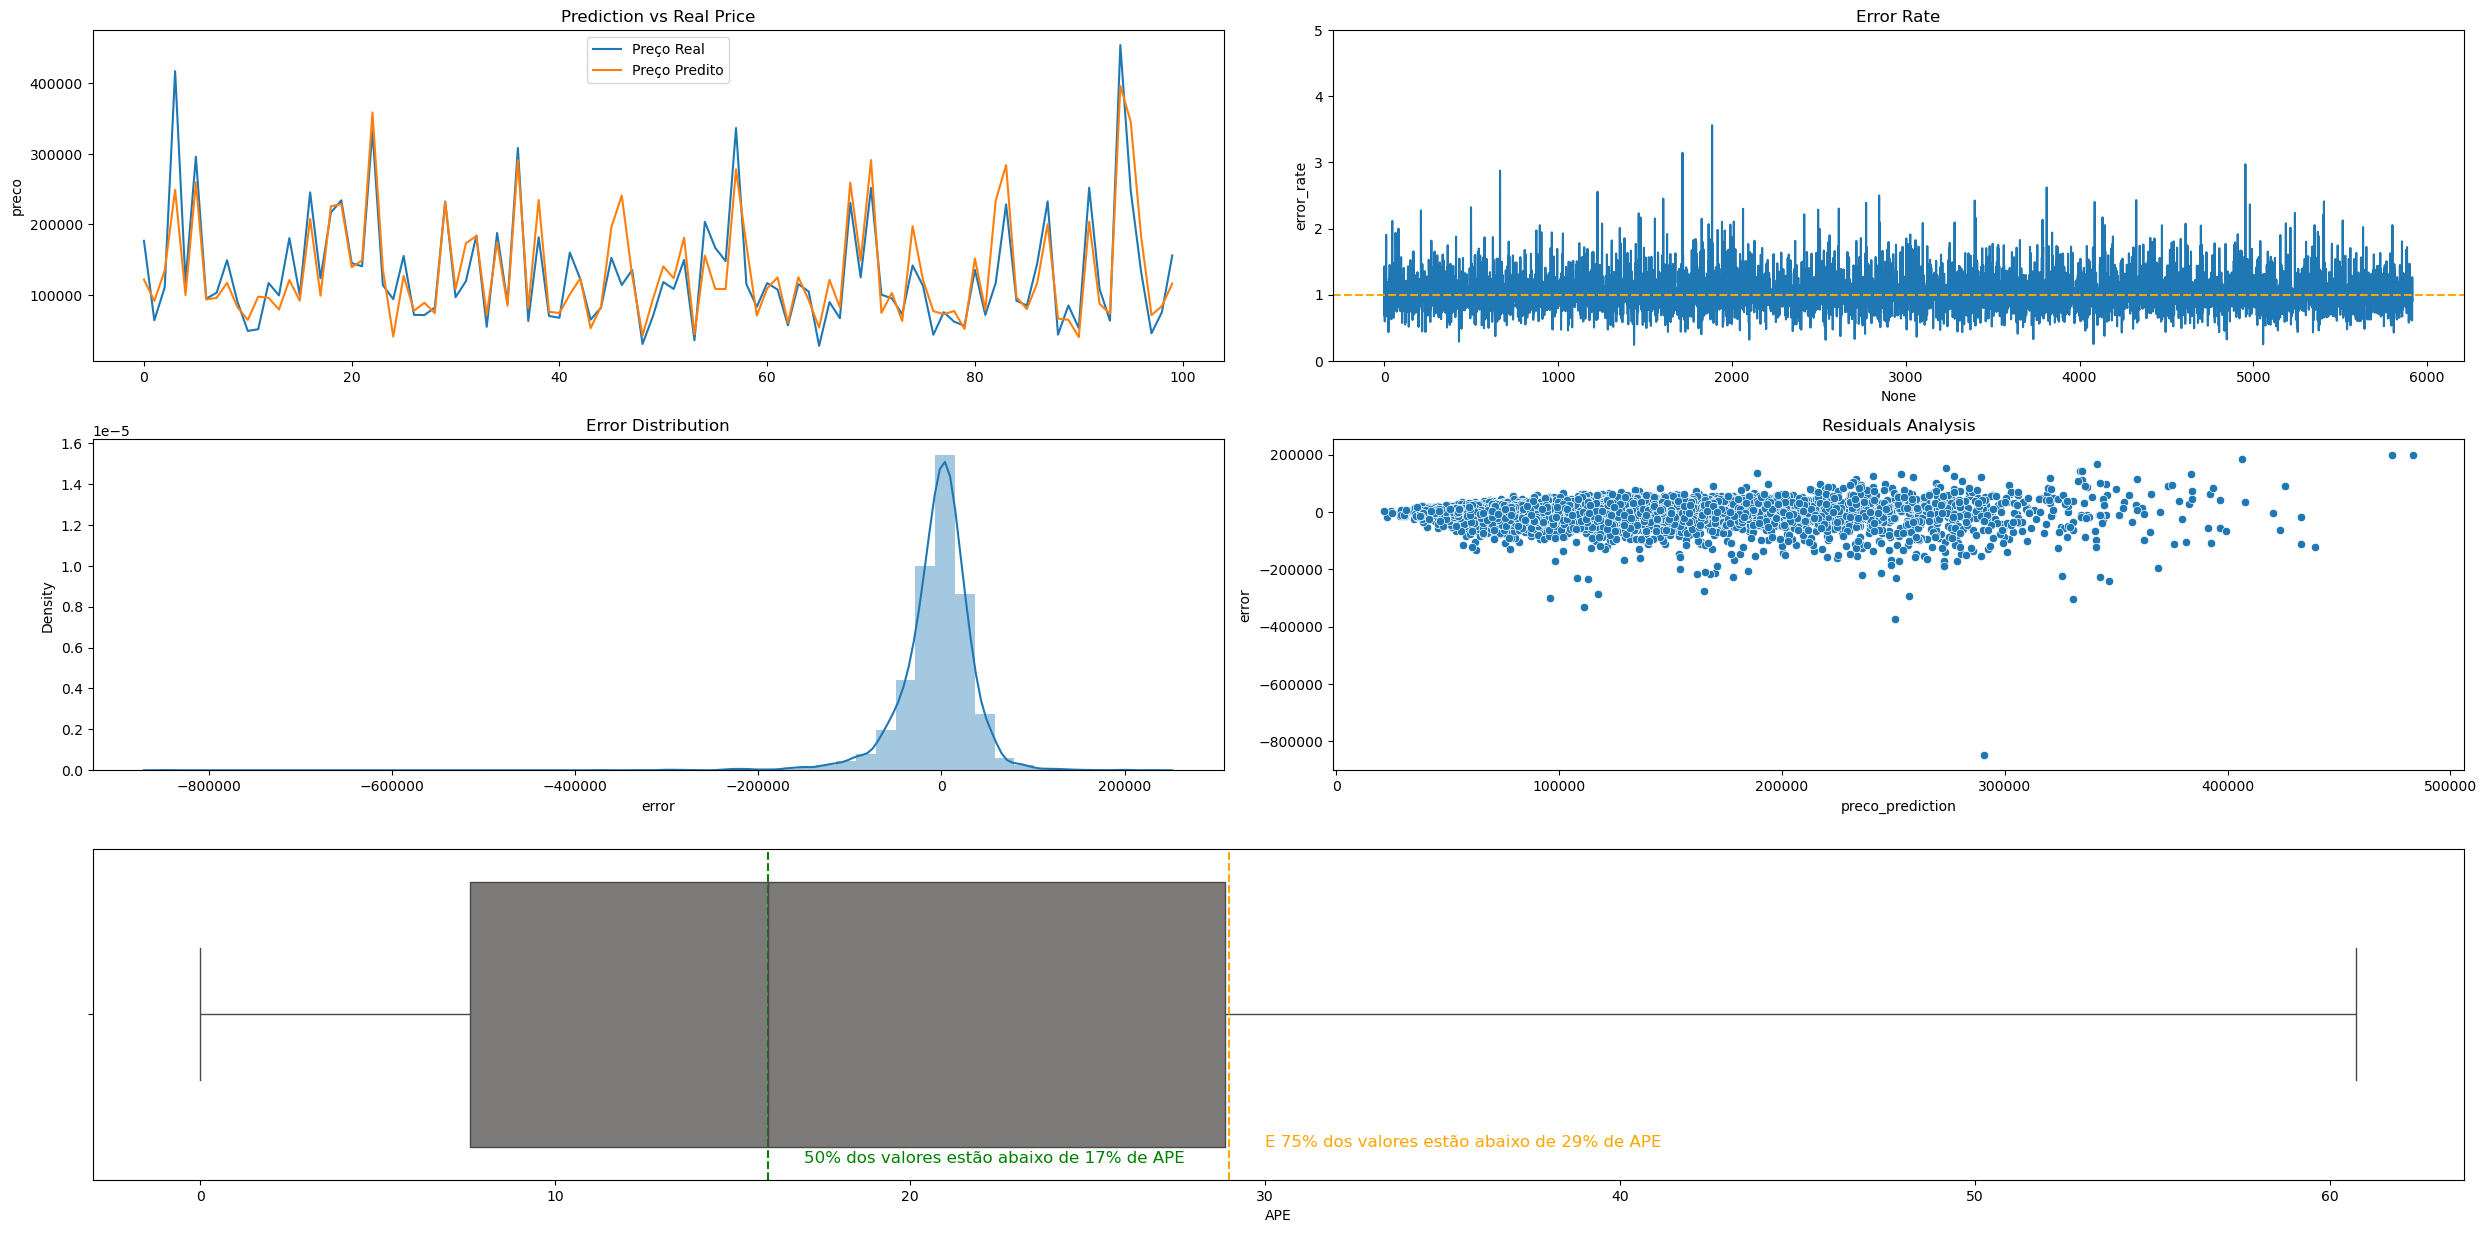

In [124]:
# Plots 
grid = gridspec.GridSpec(3, 2)
plt.figure(figsize=(25,12))

# Plot Erro Predito vs Real
plt.subplot(grid[0,0])
plt.title('Prediction vs Real Price')
sns.lineplot(x=range(0,100), y='preco', data=df9.iloc[0:100], label='Preço Real')
sns.lineplot(x=range(0,100), y='preco_prediction', data=df9.iloc[0:100], label='Preço Predito')
plt.legend()

# Plot Error Rate
plt.subplot(grid[0,1])
plt.title('Error Rate')
sns.lineplot(x=df9.index, y='error_rate', data=df9)
plt.ylim(0,5)
plt.axhline(1, linestyle='--', c='orange')

# Plot Error Distribution
plt.subplot(grid[1,0])
plt.title('Error Distribution')
sns.distplot(df9['error'])

# Plot Residuals Analysis
plt.subplot(grid[1,1])
plt.title('Residuals Analysis')
sns.scatterplot(x = 'preco_prediction', y = 'error', data=df9.loc[df9['preco_prediction']<9**6])
plt.tight_layout()

# Plot error each row
plt.subplot(grid[2,:])
sns.boxplot(x=df9['APE'], showfliers=False, palette='cividis')
plt.axvline(29, linestyle='--', c='orange')
plt.axvline(16, linestyle='--', c='green')
plt.text(17, 0.5, '50% dos valores estão abaixo de 17% de APE\n', fontsize=12, color='green')
plt.text(30, 0.4, 'E 75% dos valores estão abaixo de 29% de APE', fontsize=12, color='orange')
plt.show()